# Imports

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Data Processing

## Read data

In [59]:
data_folder = Path("data")
last_states_folder = data_folder / "last States"

In [60]:
file_names = []
for file in data_folder.glob("*.*"):
    file_names.append(file.name)

In [61]:
ls_names = []
for file in last_states_folder.glob("*.*"):
    ls_names.append(file.name)

In [62]:
ls_data_500 = np.load(last_states_folder / ls_names[2])
Ts = ls_data_500["Ts"]
len(Ts)

100

In [63]:
file_names

['N_100_avg_std_spins_energies.npz',
 'N_250_avg_std_spins_energies.npz',
 'N_300_avg_std_spins_energies.npz',
 'N_350_avg_std_spins_energies.npz',
 'N_400_avg_std_spins_energies.npz',
 'N_450_avg_std_spins_energies.npz',
 'N_500_avg_std_spins_energies.npz',
 'N_50_avg_std_spins_energies.npz',
 'N_750_avg_std_spins_energies.npz']

In [64]:
net_size_dict = {}
for idx, file in enumerate(file_names):
    Ns = int(file.split("_")[1])
    if Ns == 50:
        continue
    net_size_dict[Ns] = idx

net_size_dict

{100: 0, 250: 1, 300: 2, 350: 3, 400: 4, 450: 5, 500: 6, 750: 8}

In [65]:
all_data = {}
for N_size, idx in net_size_dict.items():
    all_data[N_size] = np.load(data_folder / file_names[idx])

In [66]:
keys = ['avg_spins', 'std_spins', 'avg_energies', 'std_energies']

In [67]:
all_data

{100: NpzFile 'data\\N_100_avg_std_spins_energies.npz' with keys: avg_spins, std_spins, avg_energies, std_energies,
 250: NpzFile 'data\\N_250_avg_std_spins_energies.npz' with keys: avg_spins, std_spins, avg_energies, std_energies,
 300: NpzFile 'data\\N_300_avg_std_spins_energies.npz' with keys: avg_spins, std_spins, avg_energies, std_energies,
 350: NpzFile 'data\\N_350_avg_std_spins_energies.npz' with keys: avg_spins, std_spins, avg_energies, std_energies,
 400: NpzFile 'data\\N_400_avg_std_spins_energies.npz' with keys: avg_spins, std_spins, avg_energies, std_energies,
 450: NpzFile 'data\\N_450_avg_std_spins_energies.npz' with keys: avg_spins, std_spins, avg_energies, std_energies,
 500: NpzFile 'data\\N_500_avg_std_spins_energies.npz' with keys: avg_spins, std_spins, avg_energies, std_energies,
 750: NpzFile 'data\\N_750_avg_std_spins_energies.npz' with keys: avg_spins, std_spins, avg_energies, std_energies}

## Formatting

In [68]:
mags, std_mags = {}, {}
for N_size, data in all_data.items():
    mags[N_size] = data["avg_spins"]
    std_mags[N_size] = data["std_spins"]

energies, std_energies = {}, {}
for N_size, data in all_data.items():
    energies[N_size] = data["avg_energies"]
    std_energies[N_size] = data["std_energies"]

In [69]:
# Get all magnetization data and error in a dictionary
# Keys are the net sizes, and values are the mean and error of the magnetization
mags_mean, mags_err = {}, {}
for N_size, data in all_data.items():
    mags_mean[N_size] = np.mean(data["avg_spins"], axis=1)
    mags_err[N_size] = np.std(data["avg_spins"], axis=1) / np.sqrt(len(data["avg_spins"]))

In [70]:
# Same thing for energies
energies_mean, energies_err = {}, {}
for N_size, data in all_data.items():
    energies_mean[N_size] = np.mean(data["avg_energies"], axis=1)
    energies_err[N_size] = np.std(data["avg_energies"], axis=1) / np.sqrt(len(data["avg_energies"]))

In [71]:
# Computing heat capacities with the formula C_v = dE/dT
Cv_grad, Cv_err_grad = {}, {}
for N_size, data in all_data.items():
    energies = data["avg_energies"]
    std_ener = data["std_energies"]
    if len(Ts) == len(energies.mean(axis=1)):
        Cv_grad[N_size] = np.gradient(energies.mean(axis=1), Ts) / (N_size**2)
        Cv_err_grad[N_size] = np.sqrt((np.gradient(std_ener.mean(axis=1), Ts) / (N_size**2))**2)
    else:
        raise ValueError(f"Length mismatch: N = {N_size} Ts has length {len(Ts)}, but energies.mean(axis=1) has length {len(energies.mean(axis=1))}.")


# Computing heat capacities using the formula C_v = (<E^2> - <E>^2)/(T^2 * N^2)
Cv_mean, Cv_err_mean = {}, {}
for N_size, data in all_data.items():
    energies = data["avg_energies"]
    Cv_mean[N_size] = (np.mean(energies**2, axis=1) - np.mean(energies, axis=1)**2) / (Ts**2 * N_size**2)
    Cv_err_mean[N_size] = np.sqrt((np.std(energies**2, axis=1) / (Ts**2 * N_size**2))**2 + (np.std(energies, axis=1)**2 / (Ts**4 * N_size**4))**2)

In [72]:
heat_capacity, heat_capacity_err = {}, {}
susceptibility, susceptibility_err = {}, {}

for N_size, data in all_data.items():
    E = data["avg_energies"]  # shape (n_temps, 20)
    M = data["avg_spins"]     # shape (n_temps, 20)
    
    E_mean = np.mean(E, axis=1)
    E2_mean = np.mean(E**2, axis=1)
    M_mean = np.mean(M, axis=1)
    M2_mean = np.mean(M**2, axis=1)
    
    T = Ts 

    Cv = (E2_mean - E_mean**2) / (T**2 * N_size**2)
    chi = (M2_mean - M_mean**2) / (T * N_size**2)
    
    # Error bars via standard error propagation (assuming 20 independent samples)
    n = E.shape[1]
    E_var = np.var(E, axis=1, ddof=1)
    M_var = np.var(M, axis=1, ddof=1)
    E2_var = np.var(E**2, axis=1, ddof=1)
    M2_var = np.var(M**2, axis=1, ddof=1)
    
    # Error propagation (standard error on difference of means)
    Cv_err = np.sqrt((E2_var + 4 * (E_mean**2) * E_var) / n) / (T**2 * N_size**2)
    chi_err = np.sqrt((M2_var + 4 * (M_mean**2) * M_var) / n) / (T * N_size**2)

    heat_capacity[N_size] = Cv
    heat_capacity_err[N_size] = Cv_err
    susceptibility[N_size] = chi
    susceptibility_err[N_size] = chi_err

In [74]:
def bootstrap_statistic(samples, func, n_boot=1000):
    boot_stats = []
    n = len(samples)
    for _ in range(n_boot):
        # Resample with replacement
        resample = np.random.choice(samples, size=n, replace=True)
        boot_stats.append(func(resample))
    return np.mean(boot_stats), np.std(boot_stats)

for N_size, data in all_data.items():

    print(f"Calculating heat capacity and susceptibility for N = {N_size}")
    E = data["avg_energies"]  # shape (n_temps, 20)
    M = data["avg_spins"]
    
    T = Ts
    Cv = []
    Cv_err = []
    Chi = []
    Chi_err = []
    
    for i in range(E.shape[0]):  # for each temperature
        E_i = E[i]
        M_i = M[i]

        def cv_fn(E_sample):
            return np.var(E_sample, ddof=1) / (T[i]**2)
        
        def chi_fn(M_sample):
            return np.var(M_sample, ddof=1) / (T[i])
        
        cv_mean, cv_std = bootstrap_statistic(E_i, cv_fn, n_boot=200)
        chi_mean, chi_std = bootstrap_statistic(M_i, chi_fn, n_boot=200)
        
        Cv.append(cv_mean)
        Cv_err.append(cv_std)
        Chi.append(chi_mean)
        Chi_err.append(chi_std)

    heat_capacity[N_size] = np.array(Cv)
    heat_capacity_err[N_size] = np.array(Cv_err)
    susceptibility[N_size] = np.array(Chi)
    susceptibility_err[N_size] = np.array(Chi_err)


Calculating heat capacity and susceptibility for N = 100
Calculating heat capacity and susceptibility for N = 250
Calculating heat capacity and susceptibility for N = 300
Calculating heat capacity and susceptibility for N = 350
Calculating heat capacity and susceptibility for N = 400
Calculating heat capacity and susceptibility for N = 450
Calculating heat capacity and susceptibility for N = 500
Calculating heat capacity and susceptibility for N = 750


In [75]:
net_size_dict

{100: 0, 250: 1, 300: 2, 350: 3, 400: 4, 450: 5, 500: 6, 750: 8}

## Simple Visualization (control)

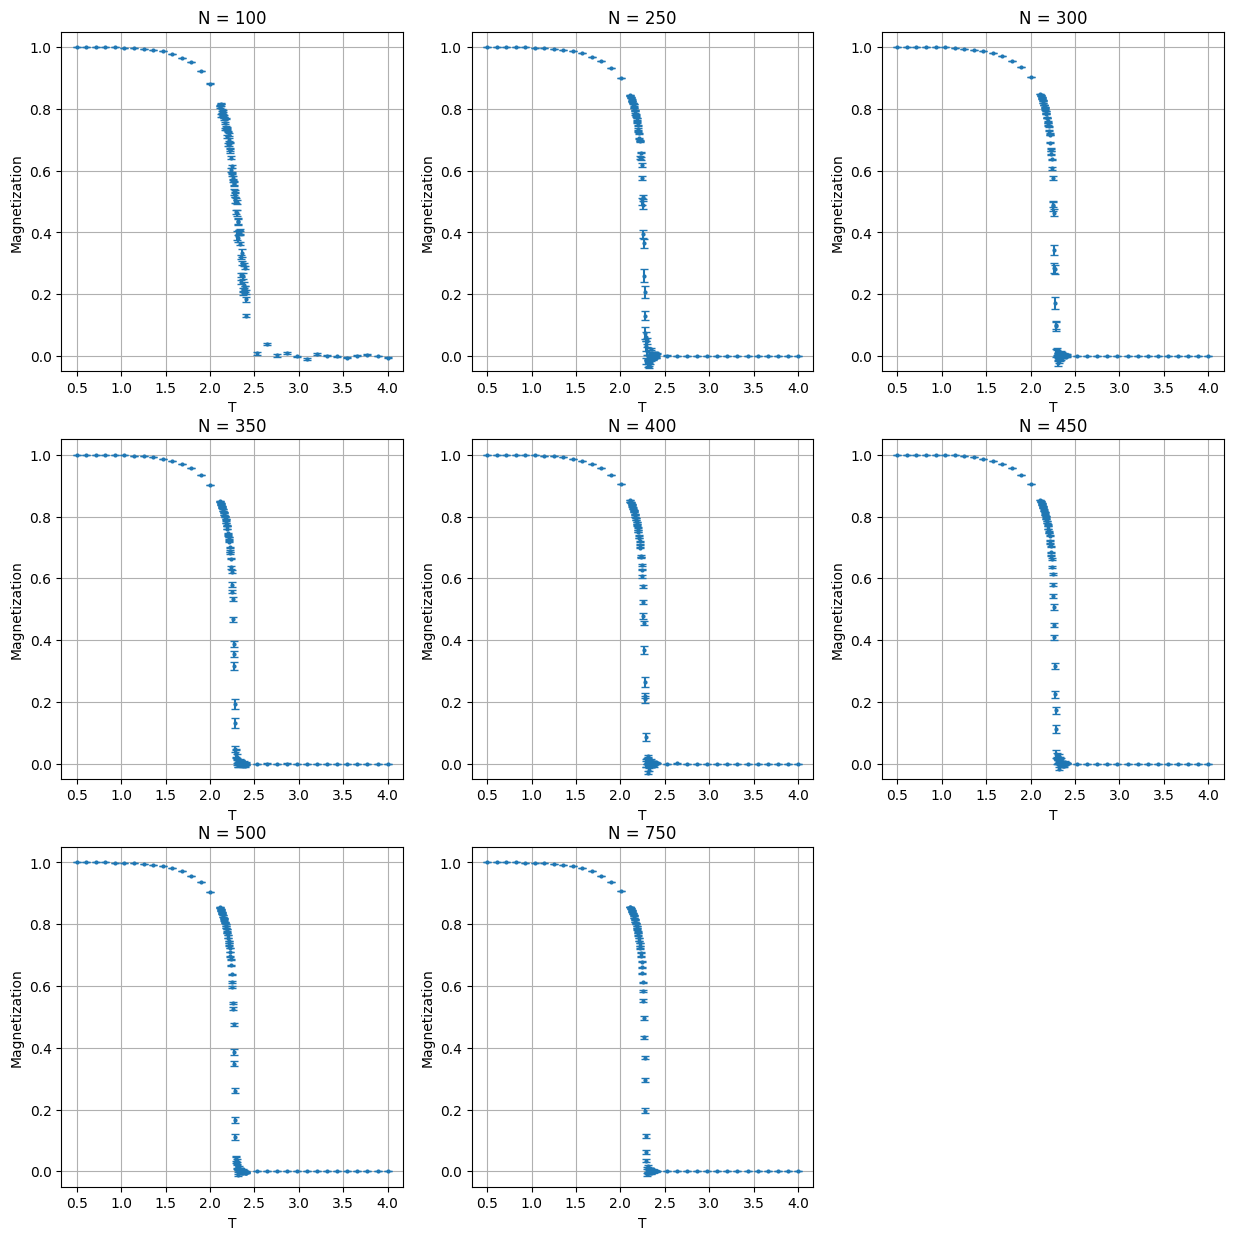

In [76]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))  # Adjusted to 3x3 to accommodate all items
axs = axs.flatten()
for i, (N_size, idx) in enumerate(net_size_dict.items()):
    axs[i].errorbar(x=Ts, y=mags_mean[N_size], yerr=mags_err[N_size], fmt='o', markersize=2, capsize=3)
    axs[i].grid()
    axs[i].set_xlabel("T")
    axs[i].set_ylabel("Magnetization")
    axs[i].set_title(f"N = {N_size}")
    axs[i].set_ylim(-0.05, 1.05)

# Hide unused subplots if any
for j in range(len(net_size_dict), len(axs)):
    axs[j].axis('off')


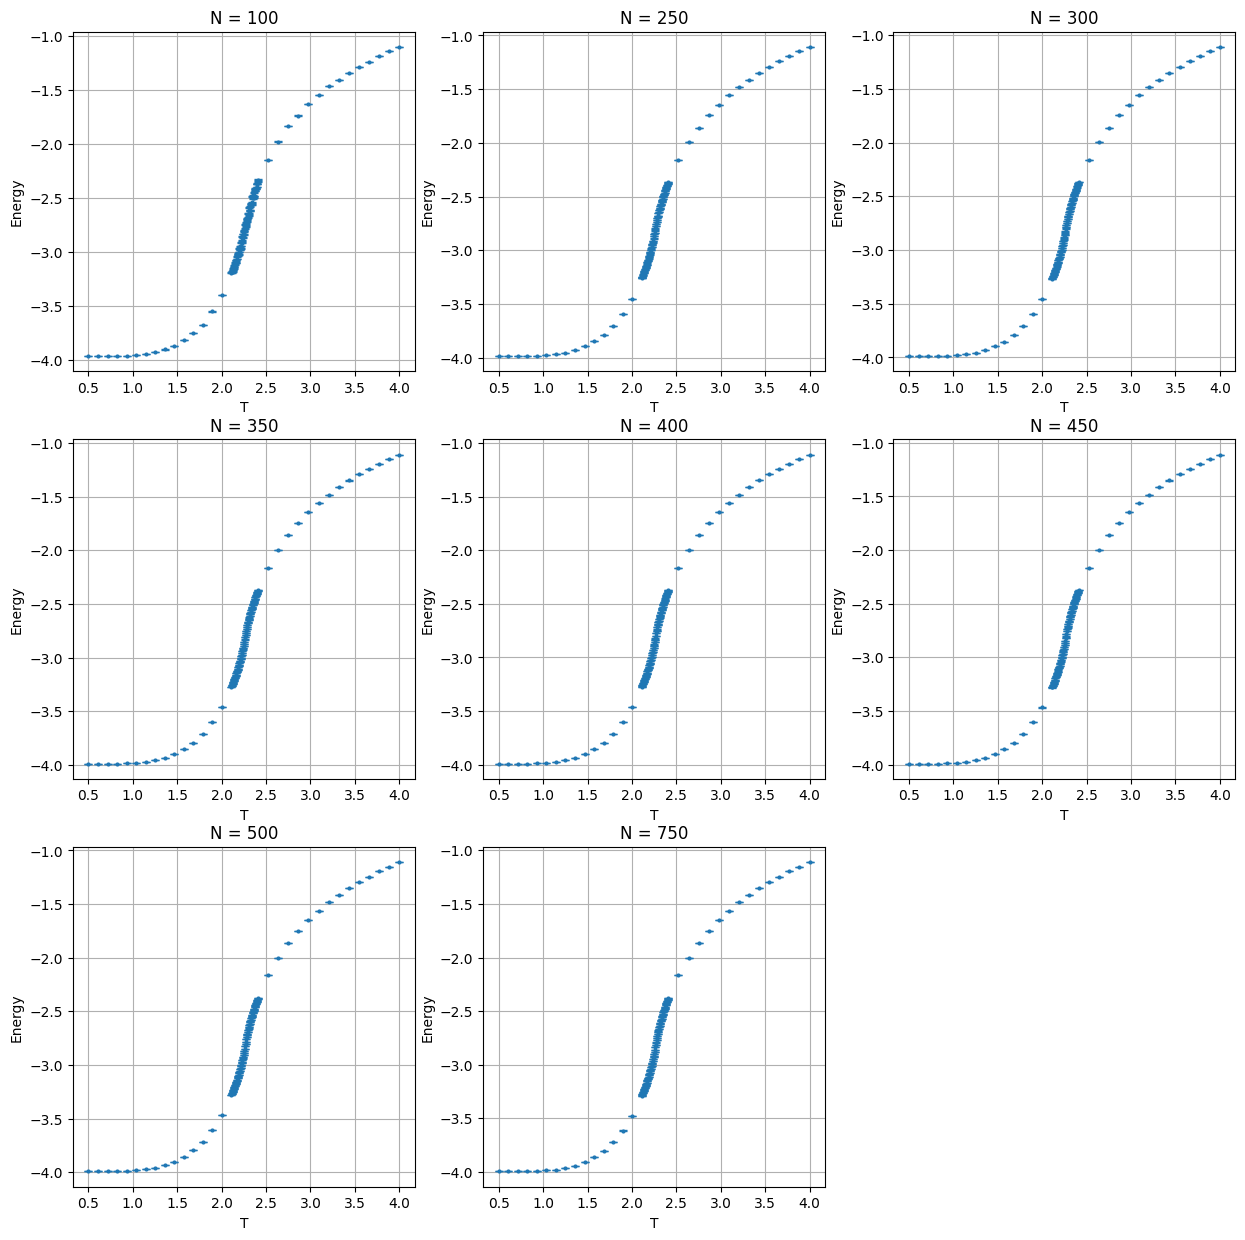

In [77]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))  # Adjusted to 3x3 to accommodate all items
axs = axs.flatten()
for i, (N_size, idx) in enumerate(net_size_dict.items()):
    axs[i].errorbar(x=Ts, y=energies_mean[N_size]/N_size**2, yerr=energies_err[N_size]/N_size**2, fmt='o', markersize=2, capsize=3)
    axs[i].grid()
    axs[i].set_xlabel("T")
    axs[i].set_ylabel("Energy")
    axs[i].set_title(f"N = {N_size}")

# Hide unused subplots if any
for j in range(len(net_size_dict), len(axs)):
    axs[j].axis('off')

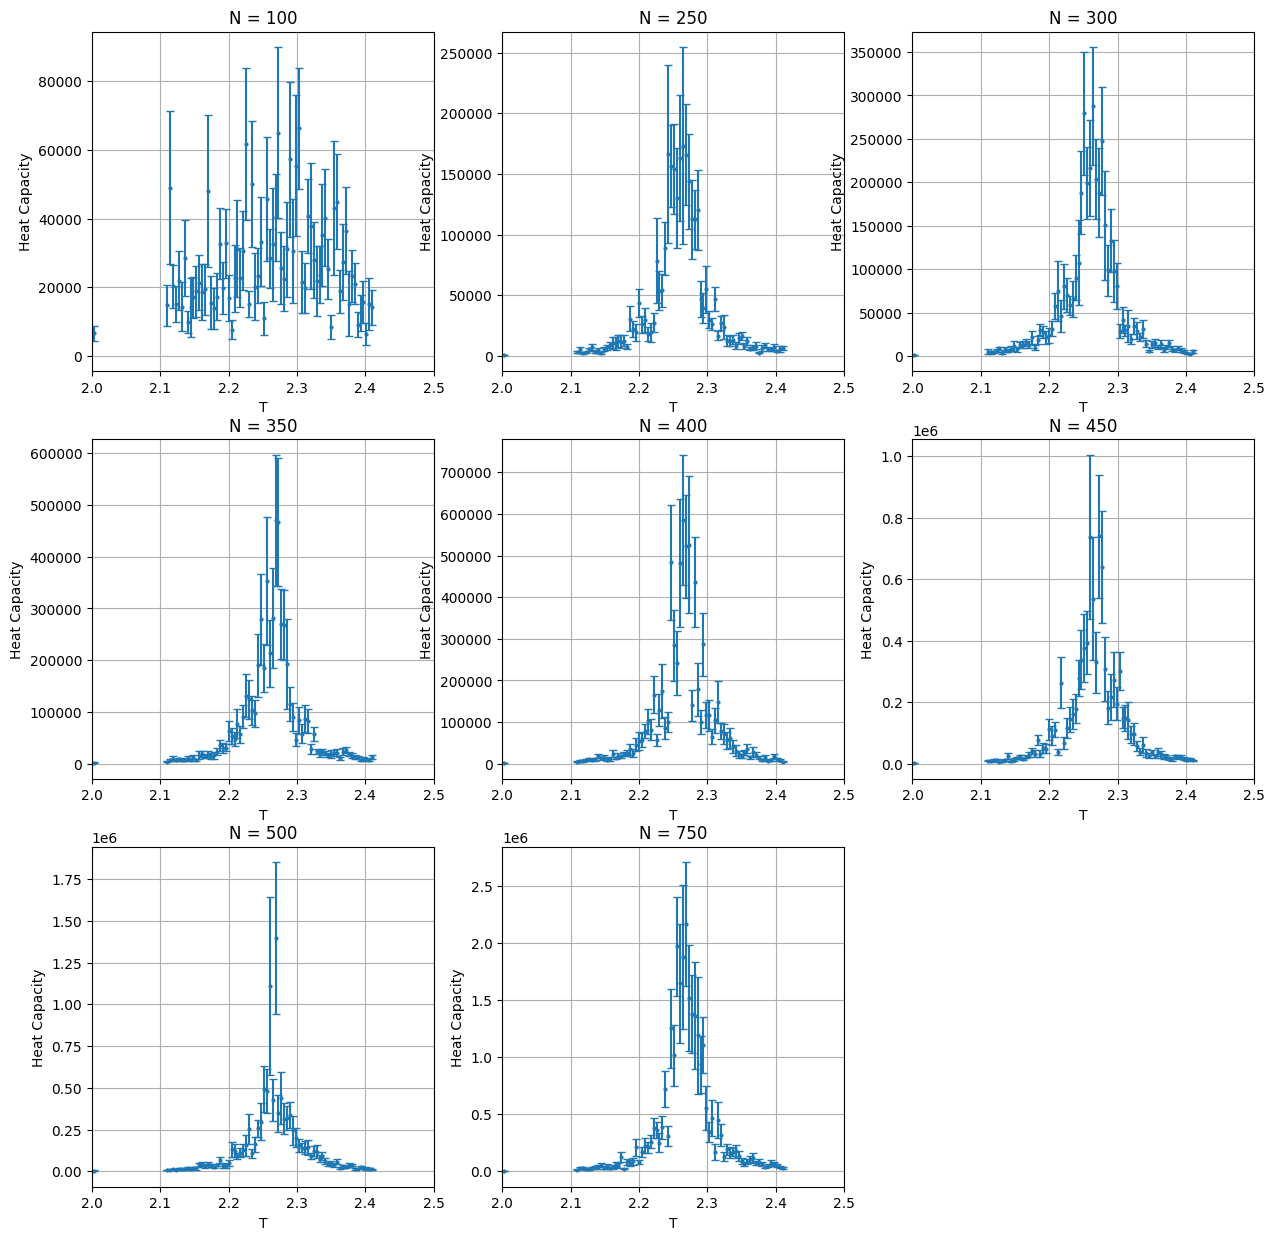

In [78]:
# Repeting the process for heat capacities (Gradient method)
fig, axs = plt.subplots(3, 3, figsize=(15, 15))  # Adjusted to 3x3 to accommodate all items
axs = axs.flatten()
for i, (N_size, idx) in enumerate(net_size_dict.items()):
    axs[i].errorbar(x=Ts, y=heat_capacity[N_size], yerr=heat_capacity_err[N_size], fmt='o', markersize=2, capsize=3)
    axs[i].grid()
    axs[i].set_xlabel("T")
    axs[i].set_ylabel("Heat Capacity")
    axs[i].set_title(f"N = {N_size}")
    axs[i].set_xlim(2.0, 2.5)


# Hide unused subplots if any
for j in range(len(net_size_dict), len(axs)):
    axs[j].axis('off')

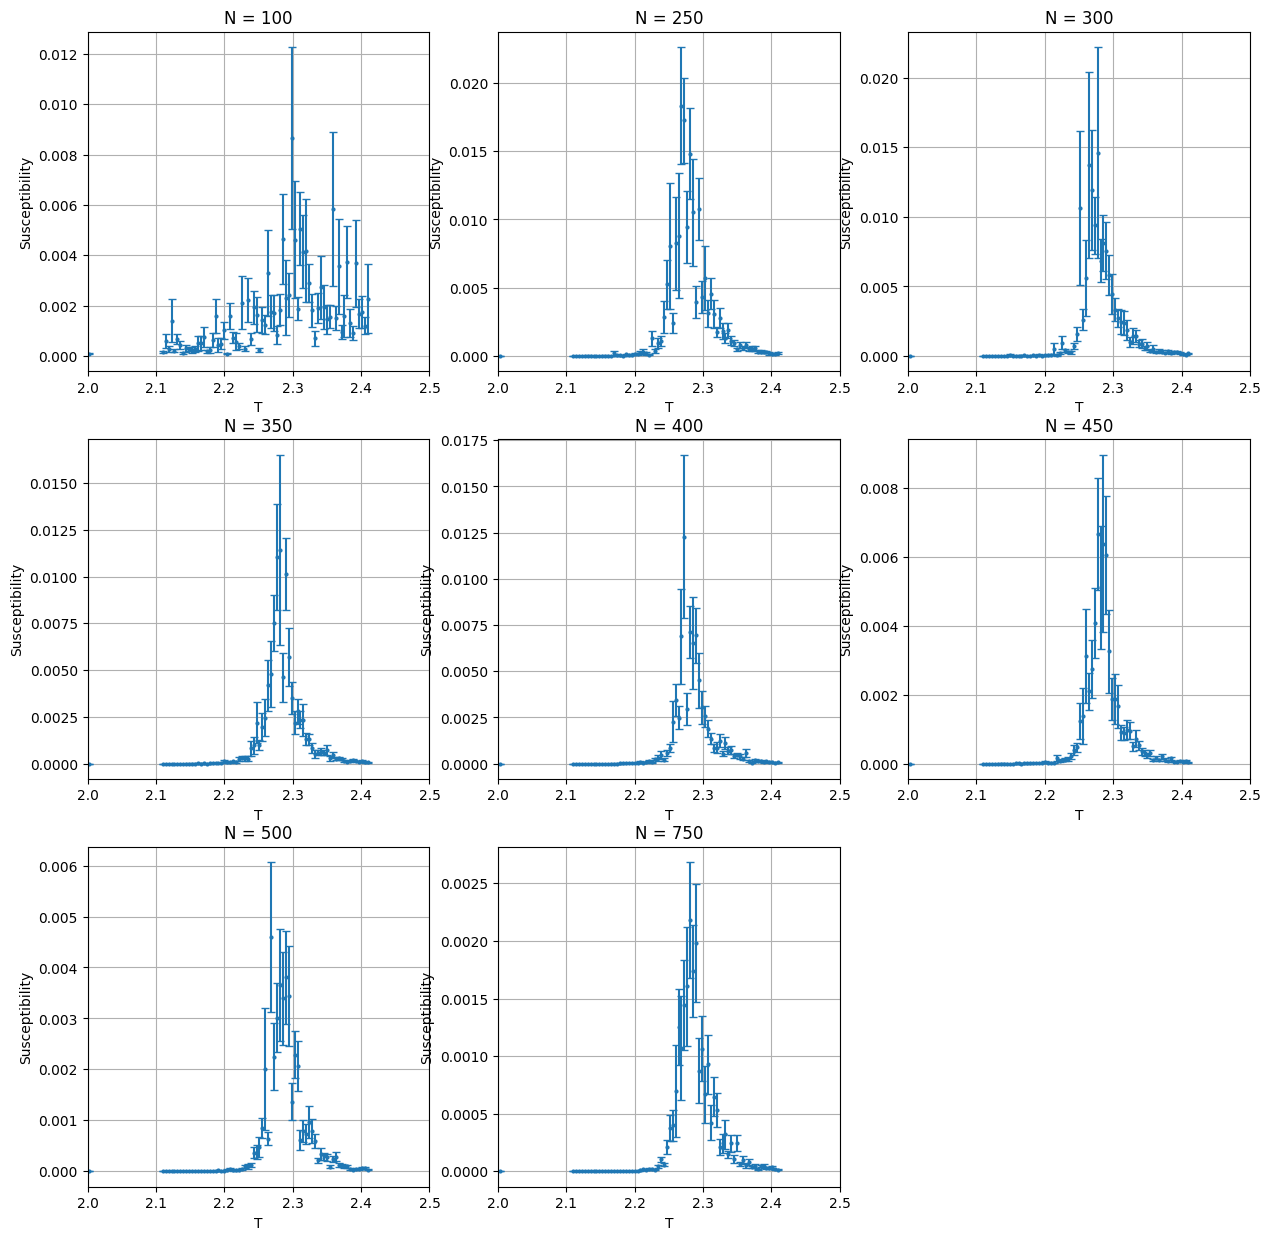

In [79]:
# Plotting susceptibility with error bars
fig, axs = plt.subplots(3, 3, figsize=(15, 15))  # Adjusted to 3x3 to accommodate all items
axs = axs.flatten()
for i, (N_size, idx) in enumerate(net_size_dict.items()):
    axs[i].errorbar(x=Ts, y=susceptibility[N_size], yerr=susceptibility_err[N_size], fmt='o', markersize=2, capsize=3)
    axs[i].grid()
    axs[i].set_xlabel("T")
    axs[i].set_ylabel("Susceptibility")
    axs[i].set_title(f"N = {N_size}")
    axs[i].set_xlim(2.0, 2.5)

# Hide unused subplots if any
for j in range(len(net_size_dict), len(axs)):
    axs[j].axis('off')

In [80]:
from Ising_Model_Fast import *

In [84]:
paths = path_configuration(N=750, T=1)

In [ ]:
for Ni_int in net_size_dict.keys(): 

    avg_mags = mags_mean[Ni_int]
    std_mags = mags_err[Ni_int]
    # Generate and save plots
    plot_quantity_vs_T(Ts, avg_mags, errors=None,
                   ylabel='Average Magnetization',
                   title=f'Magnetization vs Temperature (N={Ni_int})',
                   save_path=paths['figures'] / f'magnetization_vs_T_N{Ni_int}_NO_ERROR.png',
                   color='red', connect_points=False)

    avg_energies = energies_mean[Ni_int] / Ni_int**2
    std_energies = energies_err[Ni_int] / Ni_int**2
    plot_quantity_vs_T(Ts, avg_energies, errors=None,
                       ylabel='Average Energy',
                       title=f'Energy vs Temperature (N={Ni_int})',
                       save_path=paths['figures'] / f'energy_vs_T_N{Ni_int}_NO_ERROR.png',
                       color='green', connect_points=False)

    heat_capacities = heat_capacity[Ni_int]
    std_Cv = heat_capacity_err[Ni_int]
    plot_quantity_vs_T(Ts, heat_capacities, errors=None,
                       ylabel='Specific Heat $c_v$',
                       title=f'Specific Heat vs Temperature (N={Ni_int})',
                       save_path=paths['figures'] / f'Cv_vs_T_N{Ni_int}_NO_ERROR.png',
                       color='blue', connect_points=False)
    
    susceptibilities = susceptibility[Ni_int]
    std_chi = susceptibility_err[Ni_int]
    plot_quantity_vs_T(Ts, susceptibilities, errors=None,
                   ylabel='Susceptibility $\\chi$',
                   title=f'Susceptibility vs Temperature (N={Ni_int})',
                   save_path=paths['figures'] / f'susceptibility_vs_T_N{Ni_int}_NO_ERROR.png',
                   color='darkviolet', connect_points=False)

In [92]:
Tc_estimates = np.empty(len(net_size_dict), dtype=np.float32)
Tc_errors = np.empty(len(net_size_dict), dtype=np.float32)

for i, Ni_int in enumerate(net_size_dict.keys()):
    # Estimate Tc for this N
    heat_capacities = heat_capacity[Ni_int]
    std_Cv = heat_capacity_err[Ni_int]
    
    Tc_i, Tc_err = find_Tc(Ts, heat_capacities, std_Cv)
    Tc_estimates[i] = Tc_i
    Tc_errors[i] = Tc_err

    print(f"N={Ni_int} → Tc ≈ {Tc_i:.3f} ± {Tc_err:.3f}")
    with open(
    paths['data'] / f'Tc_N{Ni_int}.txt',
    'w', encoding='utf-8'
    ) as f:
        f.write(f"Tc = {Tc_i:.6f} ± {Tc_err:.6f}\n")

N=100 → Tc ≈ 2.307 ± 0.003
N=250 → Tc ≈ 2.262 ± 0.002
N=300 → Tc ≈ 2.265 ± 0.006
N=350 → Tc ≈ 2.272 ± 0.004
N=400 → Tc ≈ 2.263 ± 0.002
N=450 → Tc ≈ 2.272 ± 0.006
N=500 → Tc ≈ 2.333 ± 0.390
N=750 → Tc ≈ 2.252 ± 0.029


In [94]:
# Initialize arrays to store critical exponents
beta_estimates = np.empty(len(net_size_dict), dtype=np.float32)
alpha_estimates = np.empty(len(net_size_dict), dtype=np.float32)
gamma_estimates = np.empty(len(net_size_dict), dtype=np.float32)
beta_errors = np.empty(len(net_size_dict), dtype=np.float32)
alpha_errors = np.empty(len(net_size_dict), dtype=np.float32)
gamma_errors = np.empty(len(net_size_dict), dtype=np.float32)

for i, Ni_int in enumerate(net_size_dict.keys()):
    
    avg_mags = mags_mean[N_size]
    std_mags = mags_err[N_size]
    heat_capacities = heat_capacity[N_size]
    std_Cv = heat_capacity_err[N_size]
    susceptibilities = susceptibility[N_size]
    std_chi = susceptibility_err[N_size]


    # === Estimar exponentes críticos β y α cerca de Tc ===
    # === Estimar exponentes críticos β, α y γ cerca de Tc ===
    beta_fit, beta_err, alpha_fit, alpha_err, gamma_fit, gamma_err, mask_critical = estimate_critical_exponents(
        Ts,
        avg_mags, std_mags,
        heat_capacities, std_Cv,
        susceptibilities, std_chi,
        Tc_estimates[i]
    )
    
    if not np.isnan(beta_fit):
        print(f"[N={Ni_int}] Critical exponents near Tc ≈ {Tc_estimates[i]:.3f}")
        print(f"\tβ ≈ {beta_fit:.3f} ± {beta_err:.3f}")
        print(f"\tα ≈ {alpha_fit:.3f} ± {alpha_err:.3f}")
        print(f"\tγ ≈ {gamma_fit:.3f} ± {gamma_err:.3f}")
    
        # Guardar valores
        beta_estimates[i] = beta_fit
        alpha_estimates[i] = alpha_fit
        gamma_estimates[i] = gamma_fit
        beta_errors[i] = beta_err
        alpha_errors[i] = alpha_err
        gamma_errors[i] = gamma_err
    
        # Guardar a archivo
        with open(paths['data'] / f'exponentes_N{Ni_int}.txt', 'w', encoding='utf-8') as f:
            f.write(f"beta = {beta_fit:.6f} ± {beta_err:.6f}\n")
            f.write(f"alpha = {alpha_fit:.6f} ± {alpha_err:.6f}\n")
            f.write(f"gamma = {gamma_fit:.6f} ± {gamma_err:.6f}\n")
    
        # === Preparar datos log-log ===
        log_T = np.log(Tc_estimates[i] - Ts[mask_critical])
        log_M = np.log(avg_mags[mask_critical] + 1e-10)
        log_C = np.log(heat_capacities[mask_critical] + 1e-10)
        log_chi = np.log(susceptibilities[mask_critical] + 1e-10)
    
        log_M_errors = std_mags[mask_critical] / (avg_mags[mask_critical] + 1e-10)
        log_C_errors = std_Cv[mask_critical] / (heat_capacities[mask_critical] + 1e-10)
        log_chi_errors = std_chi[mask_critical] / (susceptibilities[mask_critical] + 1e-10)
    
        weights_M = 1.0 / (log_M_errors**2 + 1e-12)
        weights_C = 1.0 / (log_C_errors**2 + 1e-12)
        weights_chi = 1.0 / (log_chi_errors**2 + 1e-12)
    
        # Ajustes
        beta_fit_line, _ = np.polyfit(log_T, log_M, 1, w=weights_M, cov=True)
        alpha_fit_line, _ = np.polyfit(log_T, log_C, 1, w=weights_C, cov=True)
        gamma_fit_line, _ = np.polyfit(log_T, log_chi, 1, w=weights_chi, cov=True)
    
        fit_line_M = np.polyval(beta_fit_line, log_T)
        fit_line_C = np.polyval(alpha_fit_line, log_T)
        fit_line_chi = np.polyval(gamma_fit_line, log_T)
    
        # === Plot β ===
        plt.figure(figsize=(6, 4))
        plt.errorbar(log_T, log_M, yerr=log_M_errors, fmt='o', markersize=4,
                     color='darkorange', label='Simulated data', capsize=3)
        plt.plot(log_T, fit_line_M, 'r--', label=f'Fit (β ≈ {beta_fit_line[0]:.3f})')
        plt.xlabel(r'$\log(T_c - T)$')
        plt.ylabel(r'$\log(M)$')
        plt.title(r'Log-log fit for $\beta$ (N = %d)' % Ni_int)
        plt.grid(False)
        plt.legend()
        plt.tight_layout()
        plt.savefig(paths['figures'] / f'loglog_beta_N{Ni_int}.png', dpi=300)
        plt.close()
    
        # === Plot α ===
        plt.figure(figsize=(6, 4))
        plt.errorbar(log_T, log_C, yerr=log_C_errors, fmt='o', markersize=4,
                     color='royalblue', label='Simulated data', capsize=3)
        plt.plot(log_T, fit_line_C, 'r--', label=f'Fit (α ≈ {-alpha_fit_line[0]:.3f})')
        plt.xlabel(r'$\log(T_c - T)$')
        plt.ylabel(r'$\log(c_v)$')
        plt.title(r'Log-log fit for $\alpha$ (N = %d)' % Ni_int)
        plt.grid(False)
        plt.legend()
        plt.tight_layout()
        plt.savefig(paths['figures'] / f'loglog_alpha_N{Ni_int}.png', dpi=300)
        plt.close()
    
        # === Plot γ ===
        plt.figure(figsize=(6, 4))
        plt.errorbar(log_T, log_chi, yerr=log_chi_errors, fmt='o', markersize=4,
                     color='darkviolet', label='Simulated data', capsize=3)
        plt.plot(log_T, fit_line_chi, 'r--', label=f'Fit (γ ≈ {-gamma_fit_line[0]:.3f})')
        plt.xlabel(r'$\log(T_c - T)$')
        plt.ylabel(r'$\log(\chi)$')
        plt.title(r'Log-log fit for $\gamma$ (N = %d)' % Ni_int)
        plt.grid(False)
        plt.legend()
        plt.tight_layout()
        plt.savefig(paths['figures'] / f'loglog_gamma_N{Ni_int}.png', dpi=300)
        plt.close()

[N=100] Critical exponents near Tc ≈ 2.307
	β ≈ 0.176 ± 0.002
	α ≈ 3.753 ± 0.245
	γ ≈ 6.526 ± 0.238
[N=250] Critical exponents near Tc ≈ 2.262
	β ≈ 0.115 ± 0.000
	α ≈ 2.160 ± 0.207
	γ ≈ 3.994 ± 0.212
[N=300] Critical exponents near Tc ≈ 2.265
	β ≈ 0.118 ± 0.000
	α ≈ 2.250 ± 0.217
	γ ≈ 4.149 ± 0.221
[N=350] Critical exponents near Tc ≈ 2.272
	β ≈ 0.126 ± 0.001
	α ≈ 2.413 ± 0.205
	γ ≈ 4.058 ± 0.200
[N=400] Critical exponents near Tc ≈ 2.263
	β ≈ 0.116 ± 0.000
	α ≈ 2.207 ± 0.212
	γ ≈ 4.075 ± 0.216
[N=450] Critical exponents near Tc ≈ 2.272
	β ≈ 0.126 ± 0.001
	α ≈ 2.410 ± 0.205
	γ ≈ 4.051 ± 0.199
[N=500] Critical exponents near Tc ≈ 2.333
	β ≈ 0.251 ± 0.004
	α ≈ 3.247 ± 0.388
	γ ≈ 6.461 ± 0.366
[N=750] Critical exponents near Tc ≈ 2.252
	β ≈ 0.105 ± 0.000
	α ≈ 1.639 ± 0.271
	γ ≈ 3.444 ± 0.247


In [96]:
N_values = np.array(list(net_size_dict.keys()))
N_values

array([100, 250, 300, 350, 400, 450, 500, 750])

In [97]:
# ===========================================
#   EXTRAPOLACIÓN AL LÍMITE TERMODINÁMICO
# ===========================================
Tc_inf, Tc_err, Tc_coef = extrapolate_Tc(N_values, Tc_estimates)
print(f"Estimación Tc(∞) = {Tc_inf:.3f} ± {Tc_err:.3f}")
# Plot extrapolation
invN = 1.0 / N_values
plt.figure(figsize=(6, 4))
plt.errorbar(invN, Tc_estimates, yerr=Tc_errors, fmt='o', color='black', label='Tc(N)', capsize=3)
plt.plot(invN, Tc_coef[0]*invN + Tc_coef[1],
         'r--', label=f'Fit: Tc = {Tc_coef[0]:.2f}/N + {Tc_coef[1]:.3f}')
plt.xlabel('1/N')
plt.ylabel('Critical temperature $T_c$')
plt.title(f'Extrapolation of $T_c$ to thermodynamic limit')
plt.grid(False)
plt.tight_layout()
plt.legend()
plt.ylim(2, 6)
plt.savefig(paths['figures'] / 'Tc_extrapolation.png', dpi=300)
plt.close()

# ===========================================
#   EXTRAPOLACIÓN DE β, α Y γ AL LÍMITE N → ∞
# ===========================================
invN = 1.0 / N_values

# Extrapolar β
beta_inf, beta_err, beta_coef = extrapolate_exponent(N_values, beta_estimates, beta_errors, label='β')
plt.figure(figsize=(6, 4))
plt.errorbar(invN, beta_estimates, yerr=beta_errors, fmt='o', color='purple', label=r'$\beta(N)$', capsize=3)
plt.plot(invN, beta_coef[0]*invN + beta_coef[1],
         'r--', label=f'Fit: β = {beta_coef[0]:.2f}/N + {beta_coef[1]:.3f}')
plt.xlabel('1/N')
plt.ylabel(r'Critical exponent $\beta$')
plt.title(r'Extrapolation of $\beta$ to thermodynamic limit')
plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig(paths['figures'] / 'beta_extrapolation.png', dpi=300)
plt.close()

# Extrapolar α
alpha_inf, alpha_err, alpha_coef = extrapolate_exponent(N_values, alpha_estimates, alpha_errors, label='α')
plt.figure(figsize=(6, 4))
plt.errorbar(invN, alpha_estimates, yerr=alpha_errors, fmt='o', color='blue', label=r'$\alpha(N)$', capsize=3)
plt.plot(invN, alpha_coef[0]*invN + alpha_coef[1],
         'r--', label=f'Fit: α = {alpha_coef[0]:.2f}/N + {alpha_coef[1]:.3f}')
plt.xlabel('1/N')
plt.ylabel(r'Critical exponent $\alpha$')
plt.title(r'Extrapolation of $\alpha$ to thermodynamic limit')
plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig(paths['figures'] / 'alpha_extrapolation.png', dpi=300)
plt.close()

# Extrapolar γ
gamma_inf, gamma_err, gamma_coef = extrapolate_exponent(N_values, gamma_estimates, gamma_errors, label='γ')
plt.figure(figsize=(6, 4))
plt.errorbar(invN, gamma_estimates, yerr=gamma_errors, fmt='o', color='darkviolet',
             label=r'$\gamma(N)$', capsize=3)
plt.plot(invN, gamma_coef[0]*invN + gamma_coef[1],
         'r--', label=f'Fit: γ = {gamma_coef[0]:.2f}/N + {gamma_coef[1]:.3f}')
plt.xlabel('1/N')
plt.ylabel(r'Critical exponent $\gamma$')
plt.title(r'Extrapolation of $\gamma$ to thermodynamic limit')
plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig(paths['figures'] / 'gamma_extrapolation.png', dpi=300)
plt.close()

# Guardar resultados extrapolados
with open(
    paths['data'] / 'extrapolaciones_infinito.txt',
    'w', encoding='utf-8'
) as f:
    f.write(f"Tc(∞) = {Tc_inf:.6f} ± {Tc_err:.6f}\n")
    f.write(f"β(∞) = {beta_inf:.6f} ± {beta_err:.6f}\n")
    f.write(f"α(∞) = {alpha_inf:.6f} ± {alpha_err:.6f}\n")
    f.write(f"γ(∞) = {gamma_inf:.6f} ± {gamma_err:.6f}\n")


Estimación Tc(∞) = 2.266 ± 0.017
Estimación β(∞) = 0.100 ± 0.004 (pendiente=4.815)
Estimación α(∞) = 1.743 ± 0.195 (pendiente=187.567)
Estimación γ(∞) = 3.201 ± 0.305 (pendiente=313.825)
